# import torch

In [1]:
import mnist_train as mt

In [2]:
import time
import torch
from torch import optim
torch.__version__

'1.10.1+cu113'

# GPU check

In [3]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Download MNIST dataset

## What is MNIST dataset?
> MNIST 데이터베이스 (Modified National Institute of Standards and Technology database)는  
손으로 쓴 숫자들로 이루어진 대형 데이터베이스이며,   
다양한 화상 처리 시스템을 트레이닝하기 위해 일반적으로 사용된다.   
이 데이터베이스는 또한 기계 학습 분야의 트레이닝 및 테스트에 널리 사용된다.  
>  
> https://ko.wikipedia.org/wiki/MNIST_데이터베이스

In [4]:
from torchvision import datasets
from torchvision.transforms import ToTensor
import numpy as np
import matplotlib.pyplot as plt

train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)


In [5]:
# train data 특성
print(train_data)
print(train_data.data.size())

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
torch.Size([60000, 28, 28])


In [6]:
# 데이터에 어떤 내용이 있는지 확인
img, label = train_data[0]
print(img.shape)
print(label)

torch.Size([1, 28, 28])
5


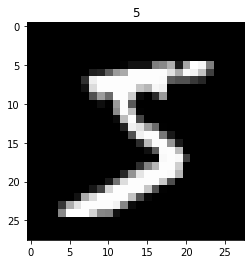

In [7]:
mt.plot_train_data(img, label)

# Plot multiple train_data

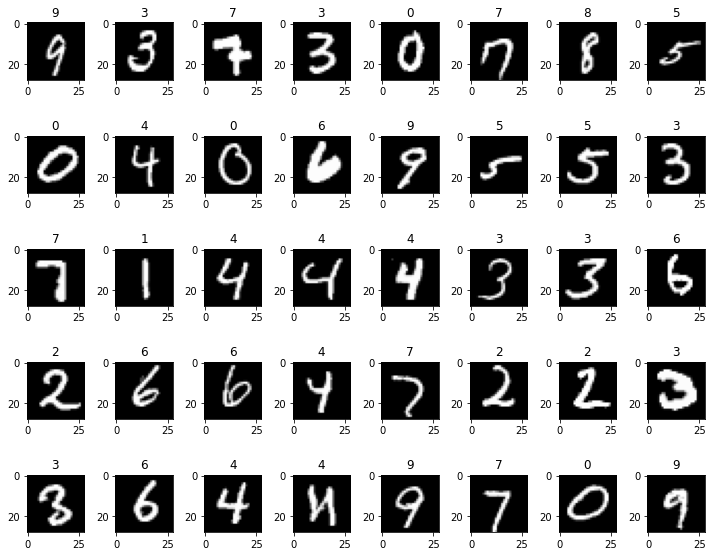

In [8]:
mt.plot_multiple_train_data(train_data, rows=5, cols=8)

# Dataloader

설정된 `batch_size` 단위로 데이터를 가져올 수 있도록 하는 모듈

In [9]:
from torch.utils.data import DataLoader
loaders = {
    'train' : torch.utils.data.DataLoader(train_data, 
                                          batch_size=100, 
                                          shuffle=True),
    
    'test'  : torch.utils.data.DataLoader(test_data, 
                                          batch_size=100, 
                                          shuffle=True, ),
}
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x1c20c27ba90>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x1c20c27bbb0>}

# Defile Model

In [40]:
import torch.nn as nn
import torch.nn.functional as F
class CNN(nn.Module):
    
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(                        # 28*28 -> 24*24  
                in_channels=1,              
                out_channels=32,            
                kernel_size=5,                      
                stride=1,                   
                padding=0,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),     # 24*24 -> 12*12
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(32, 64, 5, 1, 0),      # 12*12 -> 8*8
            nn.ReLU(),                      
            nn.MaxPool2d(2),                 # 8*8 -> 4*4
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(64 * 4 * 4, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        output = F.softmax(output, dim=1)
        
        return output    # return x for visualization

In [29]:
model = CNN()
model = model.to(device)

In [30]:
#!pip install torchsummary
from torchsummary import summary
summary(model, input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 24, 24]             832
              ReLU-2           [-1, 32, 24, 24]               0
         MaxPool2d-3           [-1, 32, 12, 12]               0
            Conv2d-4             [-1, 64, 8, 8]          51,264
              ReLU-5             [-1, 64, 8, 8]               0
         MaxPool2d-6             [-1, 64, 4, 4]               0
            Linear-7                   [-1, 10]          10,250
Total params: 62,346
Trainable params: 62,346
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.39
Params size (MB): 0.24
Estimated Total Size (MB): 0.63
----------------------------------------------------------------


> gt: 3
> image shape: torch.Size([1, 1, 28, 28])
< out: [[0.10502716 0.10440756 0.09255385 0.09783474 0.10248275 0.09412757
  0.10290869 0.09178285 0.10129145 0.10758342]]
< predicted: 9
< confidence: 0.1075834184885025


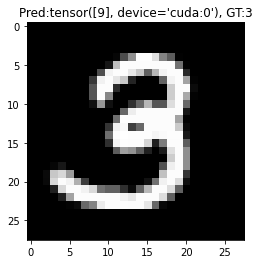

In [31]:
mt.show_sample_predict_cnn(model, device, test_data)

# Train model

In [32]:
from torch.autograd import Variable

def train(model, loaders, num_epochs, loss_func, optimizer, train_loss_list:list, test_loss_list:list):
    
    # Train the model
    total_step = len(loaders['train'])
        
    for epoch in range(num_epochs):
        loss_dict = {
            'train': 0.,
            'test': 0.
        }        
        start_time = time.time()
        
        for phase in ['train', 'test']:
        #for phase in ['train']:
            
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            for i, (images, labels) in enumerate(loaders[phase]):

                images = images.to(device, dtype=torch.float32)
                labels = labels.to(device)
                # gives batch data, normalize x when iterate train_loader
                b_x = Variable(images)   # batch x
                b_y = Variable(labels)   # batch y

                output = model(b_x)             

                loss = loss_func(output, b_y)
                loss_dict[phase] += loss.item()
                
                if phase == 'train':
                    optimizer.zero_grad()     # clear gradients for this training step               
                    loss.backward()           # backpropagation, compute gradients         
                    optimizer.step()          # apply gradients                 

                    # batch 100번 마다 로그 찍기
                    if (i+1) % 100 == 0:
                        print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.6f}' 
                               .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
    
        train_loss = loss_dict['train'] / len(loaders['train']) 
        test_loss = loss_dict['test'] / len(loaders['test']) 
        
        train_loss_list.append(train_loss)
        test_loss_list.append(test_loss)
        duration = time.time() - start_time
        print(f"Epoch [{epoch+1}/{num_epochs}] summary, train_loss:{train_loss:8.8f}, "\
              f"test_loss:{test_loss:8.8f} duration: {duration:.1f}s")

    return model, train_loss_list, test_loss_list


In [33]:
model = CNN()
model = model.to(device)
loss_func = nn.CrossEntropyLoss()   
optimizer = optim.Adam(model.parameters(), lr = 0.0001)   

train_loss_list = []
test_loss_list = []

In [39]:
model, train_loss_list, test_loss_list = train(model, loaders, 10, loss_func, optimizer, train_loss_list, test_loss_list)

Epoch [1/10], Step [100/600], Loss: 1.488165
Epoch [1/10], Step [200/600], Loss: 1.480037
Epoch [1/10], Step [300/600], Loss: 1.480456
Epoch [1/10], Step [400/600], Loss: 1.490111
Epoch [1/10], Step [500/600], Loss: 1.483304
Epoch [1/10], Step [600/600], Loss: 1.467731
Epoch [1/10] summary, train_loss:1.48403320, test_loss:1.48145140 duration: 8.9s
Epoch [2/10], Step [100/600], Loss: 1.471692
Epoch [2/10], Step [200/600], Loss: 1.493197
Epoch [2/10], Step [300/600], Loss: 1.474135
Epoch [2/10], Step [400/600], Loss: 1.478843
Epoch [2/10], Step [500/600], Loss: 1.500136
Epoch [2/10], Step [600/600], Loss: 1.481093
Epoch [2/10] summary, train_loss:1.48277361, test_loss:1.48130302 duration: 12.8s
Epoch [3/10], Step [100/600], Loss: 1.474170
Epoch [3/10], Step [200/600], Loss: 1.493482
Epoch [3/10], Step [300/600], Loss: 1.469071
Epoch [3/10], Step [400/600], Loss: 1.475132
Epoch [3/10], Step [500/600], Loss: 1.473980
Epoch [3/10], Step [600/600], Loss: 1.469776
Epoch [3/10] summary, train

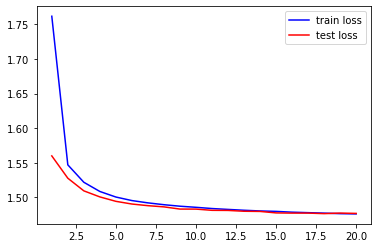

In [41]:
mt.draw_loss(train_loss_list, test_loss_list)

# Evaluate

In [42]:
def evaluate(model):
    # Test the model
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in loaders['test']:
            images = images.to(device, dtype=torch.float32)
            labels = labels.to(device)
            test_output = model(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
            pass

        print(f'Test Accuracy of the model on the {len(test_data)} test images: {accuracy*100:.2f}%')
    
    pass
evaluate(model)

Test Accuracy of the model on the 10000 test images: 98.00%


# Evaluation data sampling

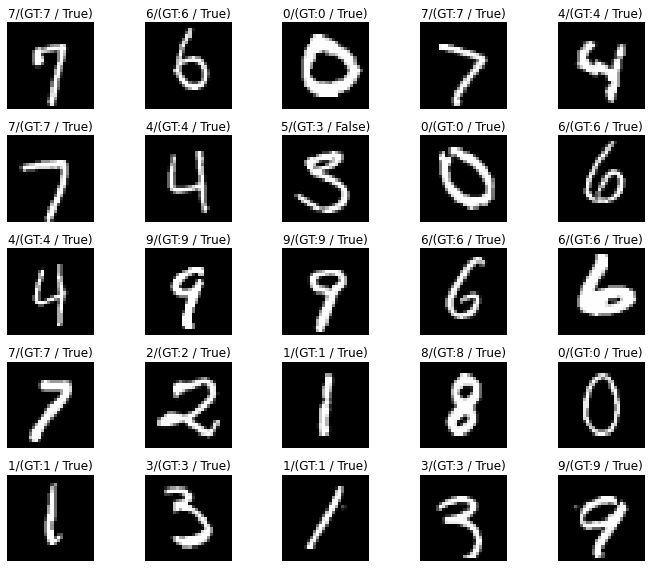

In [37]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    model.eval()
    sample_idx = np.random.randint(len(test_data), size=(1,)).item()
    img, gt = test_data[sample_idx]
    img = img.to(device)
    predicted = model(img.view(1,1,28,28))
    #label = torch.argmax(predicted)
    confidence, label = torch.max(predicted, 1)
    label = label.cpu().item()
    figure.add_subplot(rows, cols, i)
    plt.title(f"{label}/(GT:{gt} / {gt==label})")
    plt.axis("off")
    plt.imshow(img.view(28,28).cpu(), cmap="gray")

plt.tight_layout()
plt.show()

# Test

> gt: 4
> image shape: torch.Size([1, 1, 28, 28])
< out: [[2.0092904e-13 8.2953338e-13 4.4533738e-11 5.7155454e-17 1.0000000e+00
  3.4534665e-14 2.0393457e-12 7.7710678e-11 1.0374355e-13 3.9868933e-12]]
< predicted: 4
< confidence: 1.0


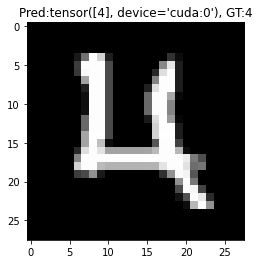

In [38]:
mt.show_sample_predict_cnn(model, device, test_data)